# A Network Science Approach To Balancing Multiplayer Online Battle Arena (MOBA) Games

## Executive Summary

In this notebook we show how Complex Network Analysis can be used as a better metric of "balance" or "fairness" in a video game (particularly Dota 2). The magnitude of the win rate alone is not enough to say which character is overpowered and which character is underpowered because it does not account for the directionality (e.g. who is that character beating). Eigenvector Centrality is a better measure because it accounts for both magnitude and direction. In addition, by creating the win rate network, we can visualize how each "patch" affects the overall "balance" of the network.

## Introduction

E-sports has become very lucrative in the last decade mainly due to micro-transactions. For example, the simple game of Candy Crush, generated up to 1.2 billion USD with micro-transactions alone. The basic idea is that video game companies create virtual items that players can buy to add on to their gaming experience. However, for this business model to work, the players themselves have to keep coming back.

The bigges problem of player vs player (PvP) games is balance. Players will not want to keep playing a game where the other party has a distinct advantage. To address this issue, game developers spend countless of hours trying different ways to balance their video game. However this is a very complex problem, with so many factors and playable characters coming into play. Using win rates as the basis for balance is not holistic due to the fact that it does not account for directionality. It's not enough for us to know how often a character is winning, but rather, we must also consider who that character is winning against!

## Dota 2 Considerations

1. It is not necessary that the hero is directly targeted by a patch for it to be balanced.
2. Balancing should be focused on the competitive / high-level meta, but due to lack of granularity we will focus on all skillbrackets.
3. Patch updates are done in batches and usually contains many changes (not limited to heroes) that affects gameplay as a whole.
4. It is not necessary that the heroes have uniform win rates, it is okay to have niche picks that focus on countering a popular pick.

## Import Packages

In [53]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

## Define Functions

In [54]:
def plot_eigen(df_eigen):
    fig, ax = plt.subplots(figsize=(15,5), dpi=150)
    ax.set_xlabel('Patches')
    ax.set_ylabel('Eigenvector Centrality')
    ax.set_title('Maximum Eigenvector Centrality')
    ax.plot(df_eigen.columns, df_eigen.max().values, 'o-')
    ax.grid()
    plt.show()

## Load The Data

The data was scraped from www.dotabuff.com; spanning from the release of patch 7.19 until February 2, 2020 patch 7.24 at the time of this writing. It should be noted that the `winrates`, `disadvantage` and `number_matches` for patch 7.24 will still change as the site data is frequently being updated.

In [55]:
df = pd.read_csv('dota_data.csv', index_col=0)
df.head()

,url,to,advantage,winrate,number_matches,patch,from
0,https://www.dotabuff.com/heroes/abaddon/counte...,anti mage,3.69,48.39,137730.0,7.19,abaddon
1,https://www.dotabuff.com/heroes/abaddon/counte...,slark,3.53,50.52,135700.0,7.19,abaddon
2,https://www.dotabuff.com/heroes/abaddon/counte...,undying,3.11,45.99,64666.0,7.19,abaddon
3,https://www.dotabuff.com/heroes/abaddon/counte...,broodmother,2.43,50.85,32125.0,7.19,abaddon
4,https://www.dotabuff.com/heroes/abaddon/counte...,enchantress,2.42,53.27,52719.0,7.19,abaddon


### Win Rate Column

For the purpose of clarity the `winrate` column label will be renamed to `winrate_from` to signify that this is the win rate of the hero in the `from` column against the hero in the corresponding `to` column.

In [56]:
df = df[['from','to','advantage','winrate','patch','number_matches']]
df.columns = ['from','to','disadvantage','winrate_from','patch','number_matches']
df.head()

,from,to,disadvantage,winrate_from,patch,number_matches
0,abaddon,anti mage,3.69,48.39,7.19,137730.0
1,abaddon,slark,3.53,50.52,7.19,135700.0
2,abaddon,undying,3.11,45.99,7.19,64666.0
3,abaddon,broodmother,2.43,50.85,7.19,32125.0
4,abaddon,enchantress,2.42,53.27,7.19,52719.0


The code below shows a sample of the win rate distribution for the hero "clockwerk" during patch 7.19. The plot shows that a hero may be highly successful (60% win rate) / highly unsuccessful (45% win rate) against a certain group of heroes. In addition, the plot is not a normal distribution with each hero having their own unique distribution.

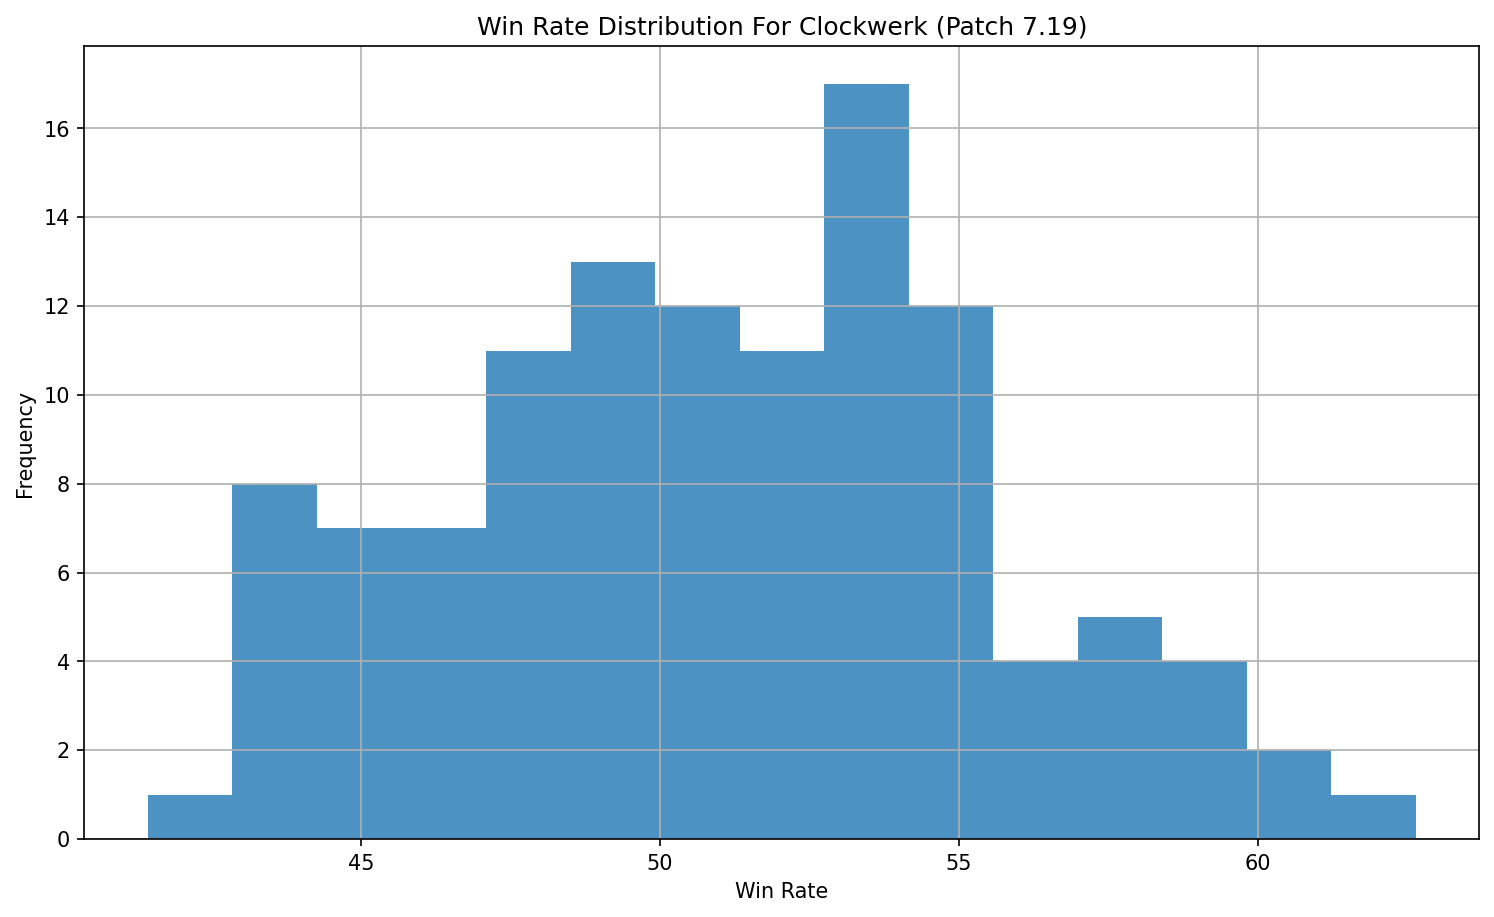

In [57]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_719 = df[df['patch']==7.19].groupby('from')
df_719.get_group('clockwerk')['winrate_from'].hist(alpha=0.8, ax=ax, bins=15)
ax.set_xlabel('Win Rate')
ax.set_ylabel('Frequency');
ax.set_title('Win Rate Distribution For Clockwerk (Patch 7.19)');

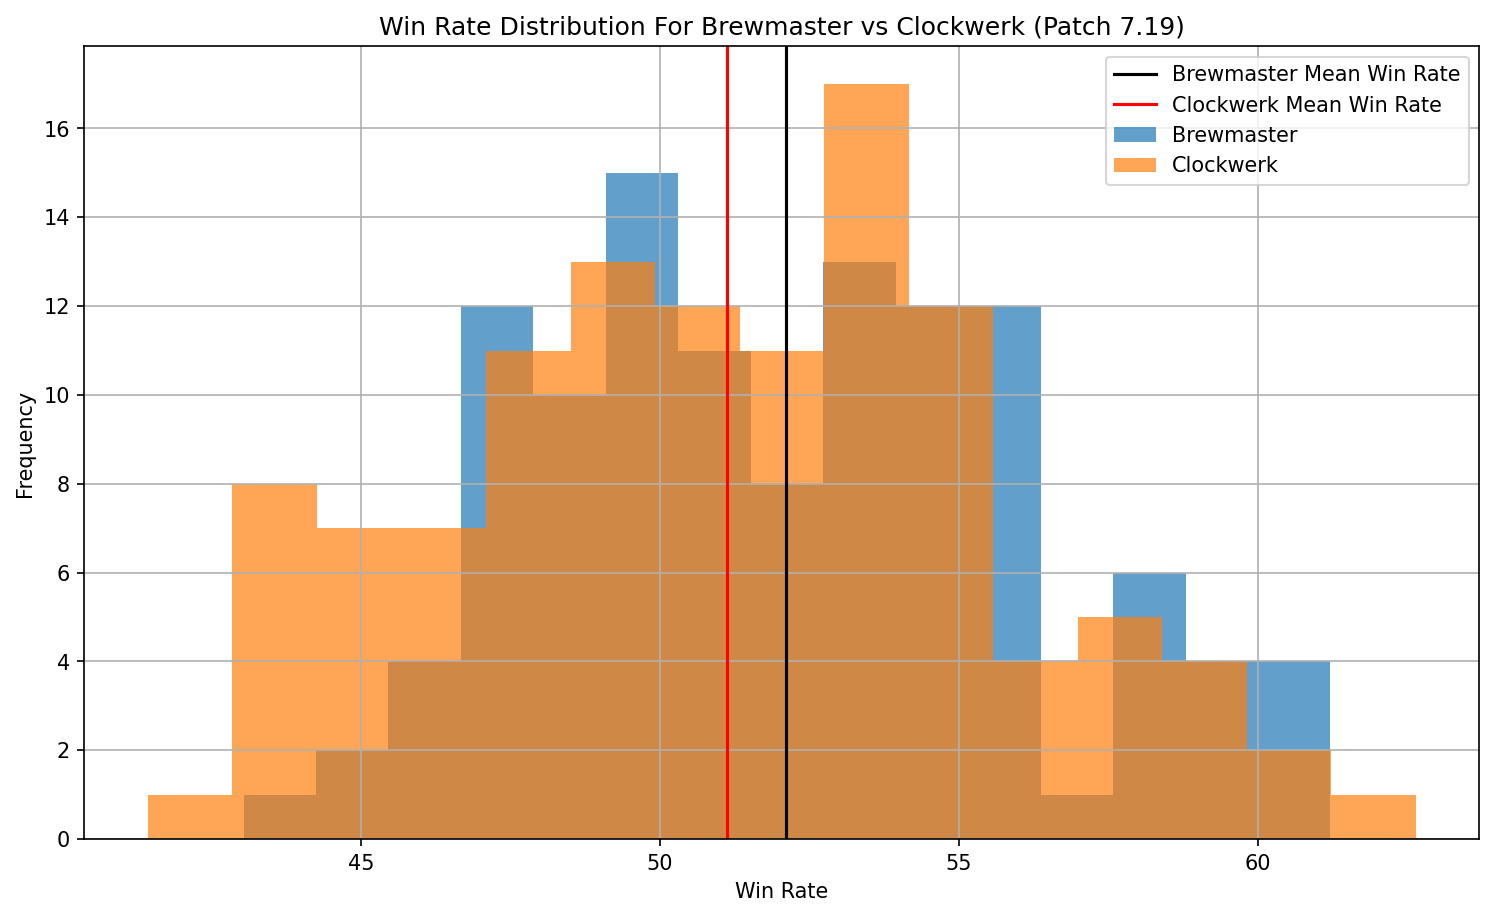

In [58]:
brew = pd.DataFrame(df_719.get_group('brewmaster')['winrate_from']).values
clock = pd.DataFrame(df_719.get_group('clockwerk')['winrate_from']).values

fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_719 = df[df['patch']==7.19].groupby('from')
ax.hist(brew, alpha=0.7, label='Brewmaster', bins=15)
ax.hist(clock, alpha=0.7, label='Clockwerk', bins=15)
ax.axvline(np.mean(brew), color='black', label='Brewmaster Mean Win Rate')
ax.axvline(np.mean(clock), color='red', label='Clockwerk Mean Win Rate')
ax.set_xlabel('Win Rate')
ax.set_ylabel('Frequency');
ax.set_title('Win Rate Distribution For Brewmaster vs Clockwerk (Patch 7.19)')
ax.legend()
ax.grid();

### Disadvantage Column

The `disadvantage` rating is dotabuff's computed disadvantage score of the hero in the `from` column against the hero in the `to` column. A positive `disadvantage` rating means that the hero in the `from` column is at a disadvantage against the hero in the `to` column. Conversely, a negative `disadvantage` rating means that the hero in the `from` column has an advantage over the hero in the `to` column.

The statistics from the latest patch of Dota 2 is changing because results of the ongoing matches are continuously being uploaded to Dotabuff. We do some cleaning to ensure that the data reflect the latest information.

In [59]:
df['pairing'] = list(map(lambda x: reduce(lambda x,y: x+'-'+y, sorted(x)), 
                         zip(df['from'],df['to'])))
df[df['pairing']=='clockwerk-sniper'].head(6)

,from,to,disadvantage,winrate_from,patch,number_matches,pairing
2184,clockwerk,sniper,-3.00,53.74,7.19,380307.0,clockwerk-sniper
10012,sniper,clockwerk,2.08,46.26,7.19,380307.0,clockwerk-sniper
15523,clockwerk,sniper,-2.62,55.07,7.20,171820.0,clockwerk-sniper
23358,sniper,clockwerk,1.33,44.93,7.20,171820.0,clockwerk-sniper
28883,clockwerk,sniper,-2.80,55.84,7.21,296410.0,clockwerk-sniper
36897,sniper,clockwerk,1.54,44.16,7.21,296410.0,clockwerk-sniper


The `advantage` / `disadvantage` computations and are not meant to be symmetrical for each pair combination as they are are based on the win rates of the two heroes in and outside of the match up. In addition, it also accounts for the hero's design wherein if the developer intentionally gave hero A certain abilities that directly counter hero B, then it follows that hero A has an advantage over hero B. Sadly, there is no documentation of how the rating was computed. However, several avid DOTA 2 players (ranks Ancient and up) have confirmed that the rating is reliable enough for the purpose of this study.

To make this easily interpretable moving forward, the team will be negating the `disadvantage` column, turning it to an `advantage` column. This new column will serve as the weights for each directed edge in the network.

In [60]:
df['advantage'] = df['disadvantage']*-1
df.head()

,from,to,disadvantage,winrate_from,patch,number_matches,pairing,advantage
0,abaddon,anti mage,3.69,48.39,7.19,137730.0,abaddon-anti mage,-3.69
1,abaddon,slark,3.53,50.52,7.19,135700.0,abaddon-slark,-3.53
2,abaddon,undying,3.11,45.99,7.19,64666.0,abaddon-undying,-3.11
3,abaddon,broodmother,2.43,50.85,7.19,32125.0,abaddon-broodmother,-2.43
4,abaddon,enchantress,2.42,53.27,7.19,52719.0,abaddon-enchantress,-2.42


### Patch Column

The patch column indicates the **major** patch version for each of the recorded statistics. It does not discriminate - rather, it aggregates all **minor** patches (e.g. 7.19a, 7.19b, 7.19c, etc.) in between major patches. This is not an issue though as minor patches only occur in the few weeks after the last major patch release. Whereas the next major patch would only be released at least a year after as the developers always wait for the tournament season to pass. This will allow the meta game to stabilize long before the next major patch.

### Number of Matches Column

Number of matches is the raw count of the matches wherein a particular hero was picked.

### Cleaning the Latest Patch Info

Since data is continuously being fed to Dotabuff, the statistics for some of the heroes might not be updated, especially the `number_matches` column and the `winrate_from` column. We adjust the win rates based on the information on the row with the higher `number_matches`

In [61]:
df['patch-pair'] = df.apply(lambda x: (x['patch'], x['pairing']), axis=1)
iterate = sorted(set(df['patch-pair']))
for entry in iterate:
    df_temp = df[df['patch-pair']==entry]
    if df_temp.iloc[0,5] != df_temp.iloc[1,5]:
        idx_max = df[df['patch-pair']==entry]['number_matches'].idxmax()
        idx_min = df[df['patch-pair']==entry]['number_matches'].idxmin()
        df.loc[idx_min, 'winrate_from'] = 100 - df.loc[idx_max, 'winrate_from']
        df.loc[idx_min, 'number_matches'] = df.loc[idx_max, 'number_matches']
df.drop('patch-pair', axis=1, inplace=True)
df

,from,to,disadvantage,winrate_from,patch,number_matches,pairing,advantage
0,abaddon,anti mage,3.69,48.39,7.19,137730.0,abaddon-anti mage,-3.69
1,abaddon,slark,3.53,50.52,7.19,135700.0,abaddon-slark,-3.53
2,abaddon,undying,3.11,45.99,7.19,64666.0,abaddon-undying,-3.11
3,abaddon,broodmother,2.43,50.85,7.19,32125.0,abaddon-broodmother,-2.43
4,abaddon,enchantress,2.42,53.27,7.19,52719.0,abaddon-enchantress,-2.42
...,...,...,...,...,...,...,...,...
82373,zeus,sand king,-2.15,56.28,7.24,64359.0,sand king-zeus,2.15
82374,zeus,monkey king,-2.36,56.02,7.24,169402.0,monkey king-zeus,2.36
82375,zeus,naga siren,-2.36,51.84,7.24,38863.0,naga siren-zeus,2.36
82376,zeus,phantom lancer,-2.42,53.14,7.24,136620.0,phantom lancer-zeus,2.42


### Sample Win Rate (Latest Patch)

In the cell below, we now look at the win rate distribution for the hero "rubick" in the latest patch (7.24).

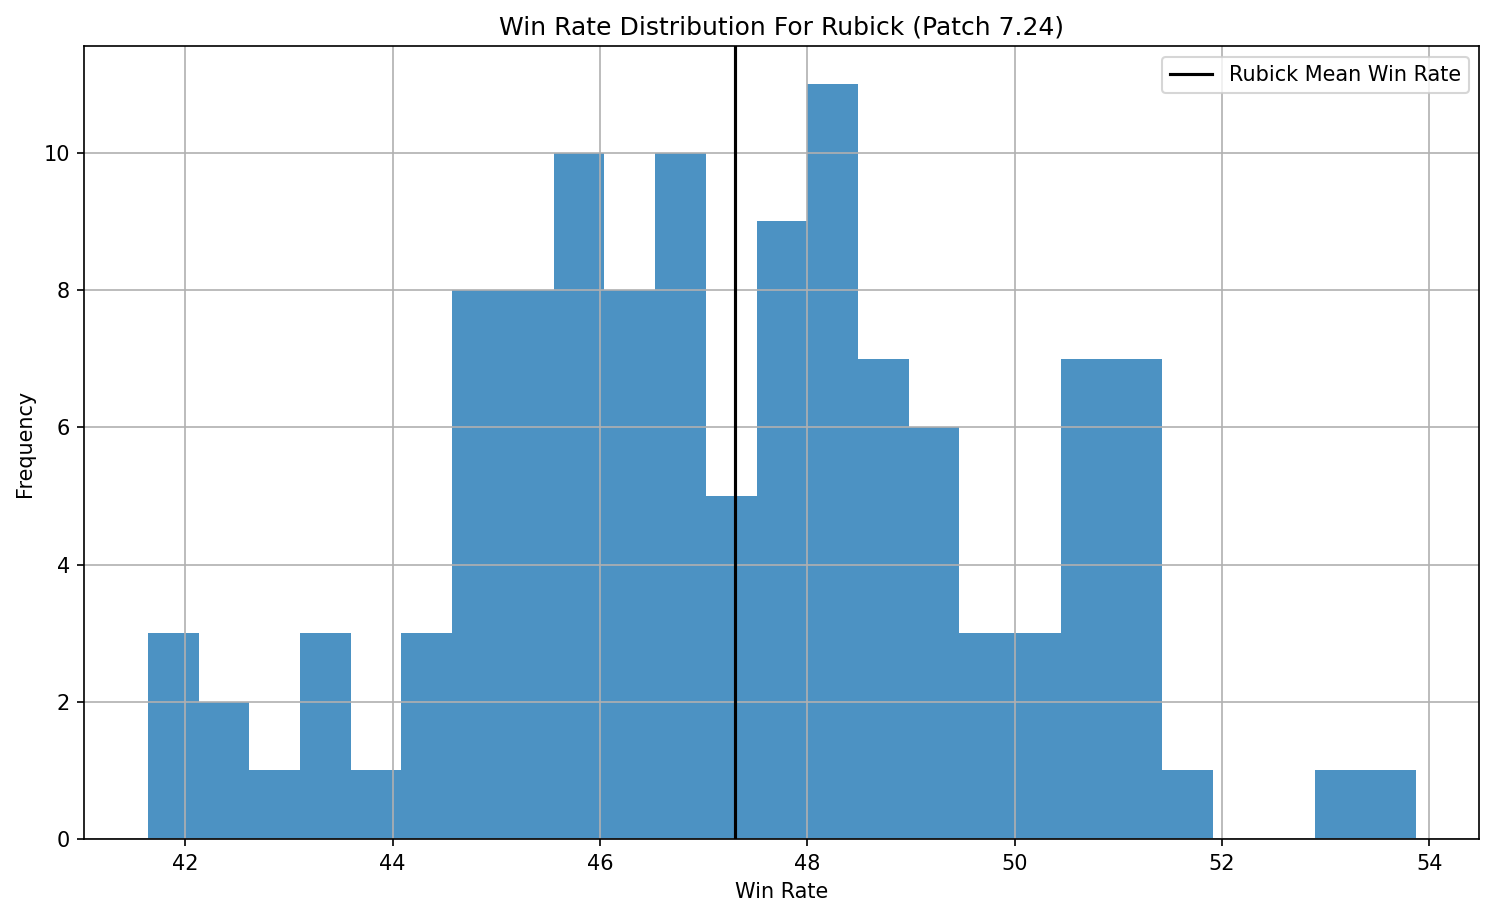

In [62]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_724 = df[df['patch']==7.24].groupby('from')
rubick = pd.DataFrame(df_724.get_group('rubick')['winrate_from']).values
df_724.get_group('rubick')['winrate_from'].hist(alpha=0.8, ax=ax, bins=25)
ax.axvline(np.mean(rubick), color='black', label='Rubick Mean Win Rate')
ax.set_xlabel('Win Rate')
ax.set_ylabel('Frequency');
ax.set_title('Win Rate Distribution For Rubick (Patch 7.24)');
ax.legend();

## Win Rate Network

To start, for each patch, a win rate network will be made. These win rate networks are weighted directed networks where the nodes are the heroes, and directed edges are weighted by the win rate of the `from` hero against the `to` hero. This will result in 2 single hop directed edges between any 2 heroes, wherein 1 edge is from A to B and the other edge is from B to A. Meanwhile the sum of their weights will always be equal to 100 percent. Refer to the table snippet below for illustration.

In [63]:
dfgroup = df.groupby(['patch','pairing'])
dfgroup.get_group((7.19,'nyx assassin-storm spirit'))

,from,to,disadvantage,winrate_from,patch,number_matches,pairing,advantage
7354,nyx assassin,storm spirit,-1.80,51.26,7.19,445872.0,nyx assassin-storm spirit,1.80
10373,storm spirit,nyx assassin,1.58,48.74,7.19,445872.0,nyx assassin-storm spirit,-1.58


### Drop Redundant Edges

No new information is being added by the 2nd path since it follows that the win rate of the 2nd hero is simply 100 minus the win rate of the first hero. And since this is not a path finding problem, there really is no need to consider the 2nd path. As such, the proponents will only be looking at the directed edges that signify a win rate advantage.

In [64]:
idx = df.groupby(['pairing','patch'])['winrate_from'].transform(max) == df['winrate_from']
df_wins = df[idx]

In [65]:
df_wins

,from,to,disadvantage,winrate_from,patch,number_matches,pairing,advantage
1,abaddon,slark,3.53,50.52,7.19,135700.0,abaddon-slark,-3.53
3,abaddon,broodmother,2.43,50.85,7.19,32125.0,abaddon-broodmother,-2.43
4,abaddon,enchantress,2.42,53.27,7.19,52719.0,abaddon-enchantress,-2.42
5,abaddon,outworld devourer,2.31,57.58,7.19,39110.0,abaddon-outworld devourer,-2.31
6,abaddon,alchemist,1.80,50.58,7.19,78021.0,abaddon-alchemist,-1.80
...,...,...,...,...,...,...,...,...
82373,zeus,sand king,-2.15,56.28,7.24,64359.0,sand king-zeus,2.15
82374,zeus,monkey king,-2.36,56.02,7.24,169402.0,monkey king-zeus,2.36
82375,zeus,naga siren,-2.36,51.84,7.24,38863.0,naga siren-zeus,2.36
82376,zeus,phantom lancer,-2.42,53.14,7.24,136620.0,phantom lancer-zeus,2.42


### Zero Centering

All win rates will then be subtracted by 50 for easier interpretation. Thus, the heroes who are evenly matched (win rate of 50) will now have a win rate equal to 0, those who win over another hero will have a positive win rate, and those who lose will have a negative win rate.

In [66]:
df_wins['winrate_from'] = df_wins['winrate_from'] - 50

/Users/tinabargo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Remove Zero Win Rate Advantage

Edges with 0 weights (0 percent win rate advantage) will also be removed as they do not indicate any advantages between the two heroes in question.

In [67]:
df_wins = df_wins[df_wins['winrate_from']>0]

In [68]:
df_wins.shape

(41162, 8)

### Win Rate Network per Patch

For each patch, a win rate network will be made and stored in a dictionary. The nodes are the heroes, and the edges are the win rates of one hero over another hero. The direction of the edge will point from the hero with the lower win rate to the hero with the higher win rate. Meanwhile, the centrality statistics (eigen, in and out) of each graph will also be stored as dataframes.

In [69]:
patches = ['7.19', '7.20', '7.21', '7.22', '7.23', '7.24']
eigen_central = []
in_central = []
out_central = []
graph_holder = {}
for patch in patches:
    df_tmp = df_wins[df_wins['patch']==float(patch)]
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(df_tmp[['to','from','winrate_from']].values)
    graph_holder.update({patch:graph})
    eigen_central.append(nx.eigenvector_centrality(graph, weight='winrate'))
    in_central.append(nx.in_degree_centrality(graph))
    out_central.append(nx.out_degree_centrality(graph))

#### Network Visualizations

This graphs for each patch are stored in this dictionary for visualization and further analysis.

In [70]:
graph_holder

{'7.19': <networkx.classes.digraph.DiGraph at 0x12c7ed278>,
 '7.20': <networkx.classes.digraph.DiGraph at 0x12b651cf8>,
 '7.21': <networkx.classes.digraph.DiGraph at 0x12dacb390>,
 '7.22': <networkx.classes.digraph.DiGraph at 0x12dacba20>,
 '7.23': <networkx.classes.digraph.DiGraph at 0x12dacb550>,
 '7.24': <networkx.classes.digraph.DiGraph at 0x12dadbcc0>}

We look at the basic statistics of the win rate network that we generated.

In [71]:
graph_holder['7.24'].number_of_nodes()

119

In [72]:
graph_holder['7.24'].number_of_edges()

7017

In [73]:
nx.density(graph_holder['7.24'])

0.4997151402934055

We generate the adjacency matrix and export to a csv file, which will be imported in Gephi for visualization.

In [74]:
nodes = list(graph_holder['7.24'].nodes())

In [75]:
df_adj = pd.DataFrame(nx.to_numpy_matrix(graph_holder['7.24']),
                      index=nodes, columns=nodes)
df_adj.to_csv('adj.csv')

#### Centrality Scores per Patch

The centrality scores of each hero across different patches are stored in the dataframes below. Note that there are some heroes (snap fire and void spirit) that have NaN values for centrality scores in earlier patches (columns). This is because these heroes were only added recently and were not present in earlier versions of the game. Analysis of these results are in the next section.

In [76]:
df_eigen = pd.DataFrame(eigen_central, index=patches).T
df_in = pd.DataFrame(in_central, index=patches).T
df_out = pd.DataFrame(out_central, index=patches).T

In [77]:
df_eigen.sort_values(by='7.24', ascending=False)[:10]

,7.19,7.20,7.21,7.22,7.23,7.24
slardar,0.009269,0.065195,0.024860,0.037691,0.119168,0.245279
underlord,0.146813,0.250237,0.212410,0.243193,0.257627,0.236199
vengeful spirit,0.200338,0.192865,0.162977,0.160422,0.242057,0.218067
meepo,0.155641,0.130960,0.103725,0.207684,0.204351,0.211713
clockwerk,0.029372,0.036506,0.057538,0.127379,0.194447,0.205628
lifestealer,0.001160,0.003547,0.107735,0.065379,0.124204,0.203664
ogre magi,0.091813,0.007704,0.060836,0.083956,0.156966,0.203569
huskar,0.009697,0.181715,0.010803,0.039977,0.110768,0.197415
bloodseeker,0.103656,0.129238,0.226772,0.113592,0.206000,0.192505
riki,0.284724,0.049603,0.153531,0.215611,0.111894,0.173509


In [78]:
df_out.sort_values(by='7.24', ascending=False)[:10]

,7.19,7.20,7.21,7.22,7.23,7.24
leshrac,0.817391,0.878261,0.818966,0.898305,0.991525,1.000000
gyrocopter,0.886957,0.930435,0.810345,0.618644,0.949153,0.991525
natures prophet,0.965217,0.904348,0.853448,0.957627,0.796610,0.957627
earth spirit,0.913043,0.739130,0.922414,0.949153,1.000000,0.957627
tiny,0.947826,0.634783,0.939655,0.949153,0.449153,0.957627
tinker,0.556522,0.721739,0.965517,0.745763,0.847458,0.932203
io,1.000000,1.000000,0.939655,0.966102,0.652542,0.906780
viper,0.678261,0.400000,0.051724,0.135593,0.813559,0.898305
ember spirit,0.582609,0.843478,0.655172,0.745763,0.855932,0.889831
doom,0.747826,0.443478,0.534483,0.779661,0.364407,0.889831


In [79]:
df_in.sort_values(by=['7.24'], ascending=False)[:10]

,7.19,7.20,7.21,7.22,7.23,7.24
slardar,0.373913,0.660870,0.482759,0.500000,0.762712,0.983051
underlord,0.826087,0.965217,0.931034,0.983051,1.000000,0.974576
vengeful spirit,0.913043,0.904348,0.870690,0.864407,0.983051,0.949153
ogre magi,0.773913,0.382609,0.681034,0.711864,0.864407,0.932203
clockwerk,0.573913,0.565217,0.646552,0.788136,0.906780,0.923729
lifestealer,0.173913,0.234783,0.758621,0.576271,0.762712,0.923729
bloodseeker,0.773913,0.782609,0.948276,0.745763,0.932203,0.915254
huskar,0.382609,0.852174,0.275862,0.491525,0.703390,0.906780
meepo,0.834783,0.756522,0.672414,0.898305,0.872881,0.906780
jakiro,0.573913,0.808696,0.836207,0.805085,0.762712,0.881356


## Analysis and Interpretation of The Win Rate Centrality Measures

### Eigenvector Centrality

**Eigenvector centrality, in a directed network graph, gives higher scores to nodes that are being referred to (pointed at) by other high scoring nodes. In addition, the edge weights also affect the eigenvector centrality score; the larger the weight, the larger the eigenvector centrality score.**

In the previous section it was mentioned that the win rate network had to first be reversed prior to the computation. This is because the convention thus far was to treat the directed edge as a notation of **advantage** of the `from` hero over the `to` hero. Computing the eigenvector centrality of the original network would result in high eigenvector centrality scores for underpowered heroes because most of the nodes are pointing towards them (and with high edge weights too). To avoid confusion, the graph needed to be reversed prior to computation. This turned the edges into a notation of **disadvantage**, thus resulting in the overpowered heroes receiving higher eigenvector centrality scores.

#### Significance

Eigenvector centrality allows for a more holistic view of balance because we are able to account for *directionality*. For instance, consider a hard counter hero; a hero that is *extremely effective versus a select few of heroes*. The hard counter may have lower win rates against the majority of heroes but this can be offsetted by high win rates against popular heroes. Looking at just the average win rates would result to the developers thinking that the hard counter hero is underpowered when it isn't. By looking at the eigenvector centrality of each hero, developers are able to account for the following:

1. For a selected hero, who are the other heroes that it can beat?
    * Given by the heroes who are pointing towards the selected hero.
2. How strong are those heroes that it can beat?
    * Given by the centrality measure of the other heroes that are pointing to the selected hero.
3. By how much can the selected hero beat those heroes?
    * Given by the weights of the edges wherein larger the edge weights lead to larger the centrality scores.  

#### Eigenvector Centrality Distributions Across Patches

Below are the histogram of eigenvector centralities across the 6 patches. It can be seen that the distributions are exponential in nature. Wherein for each patch there are usually 30-40 heroes (~35% of the maximum hero pool) that are underpowered. On the other hand, for each patch, there exist a small group of strong heroes that dominate the meta. The implications of this is that, in theory, if a player wants to increase his / her chances of winning the game then he / she should focus on the top tier heroes whilst avoiding the 30-40 low tier heroes.

Looking at the trends though across patches, it can be seen that the number of underpowered heroes is actually going down. In patch 7.19 there's around 45 heroes that are underpowered, however by patch 7.24 its just around 35.

/Users/tinabargo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


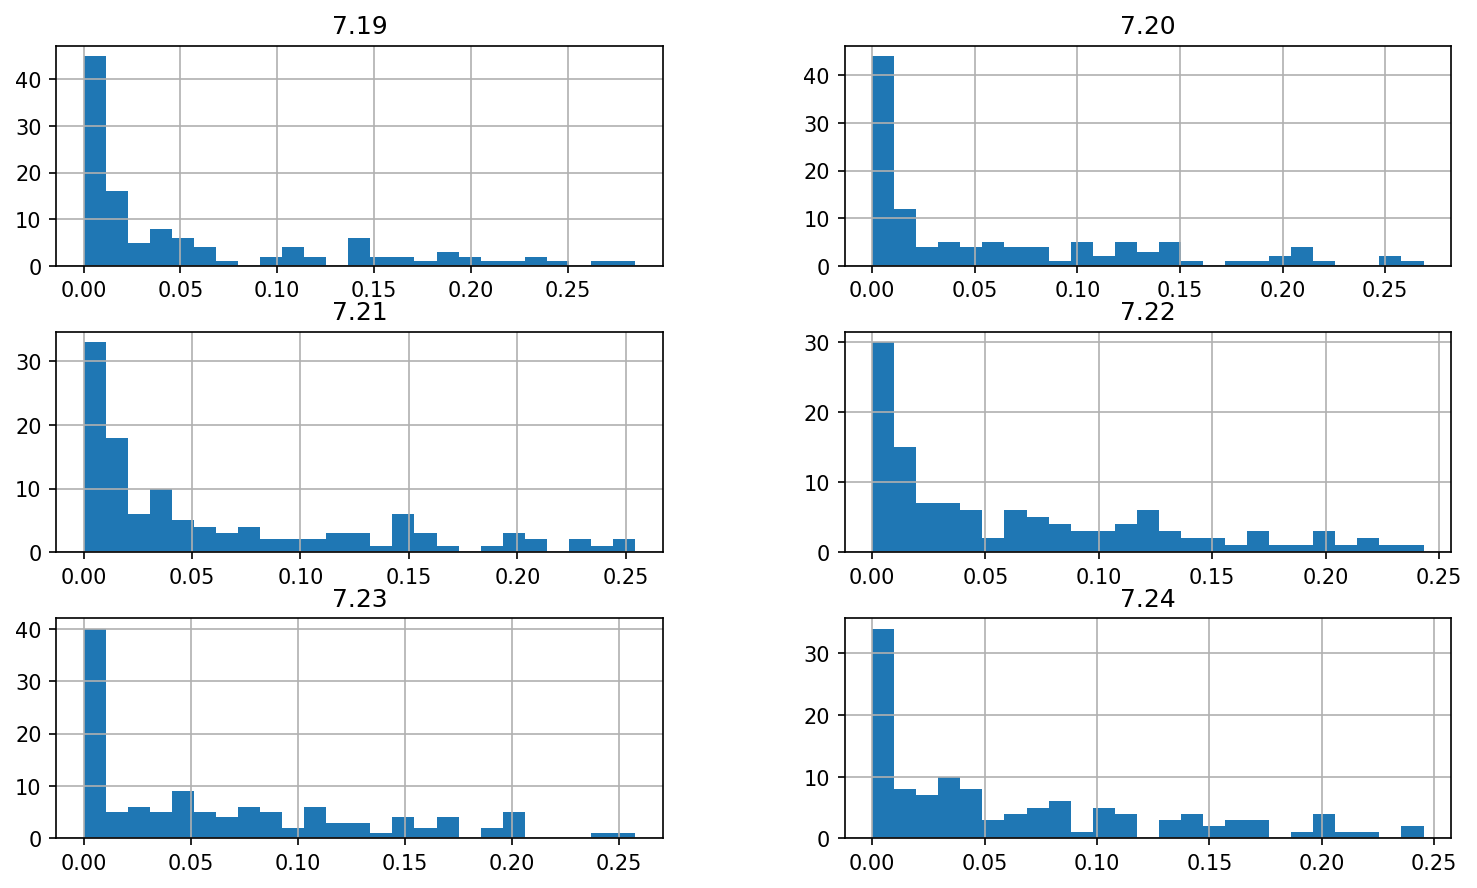

In [80]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_eigen.hist(figsize=(12,10),bins=25, ax=ax);

#### Eigenvector Centrality Statistics Across Patches

The plot on the left shows the trend for the maximum eigenvector centrality score, wherein it can clearly be seen that the max values tend to decrease with each new patch. **This means that the overpowered heroes of each new patch tend to be weaker in comparison to the overpowered heroes of the previous patches.** This has 2 main positive implications. First is that dealing with a "meta hero" is not as difficult as it was before. Second is that developers are getting better at "capping" the strengths of heroes.

One interesting observation here is the spike at patch 7.23 wherein there was a drastic change to the original game dynamics. Because apart from changing the existing items and heroes, the developers also introduced 62 new items along with 2 new heroes. This would understandably shake up the balance of the game.

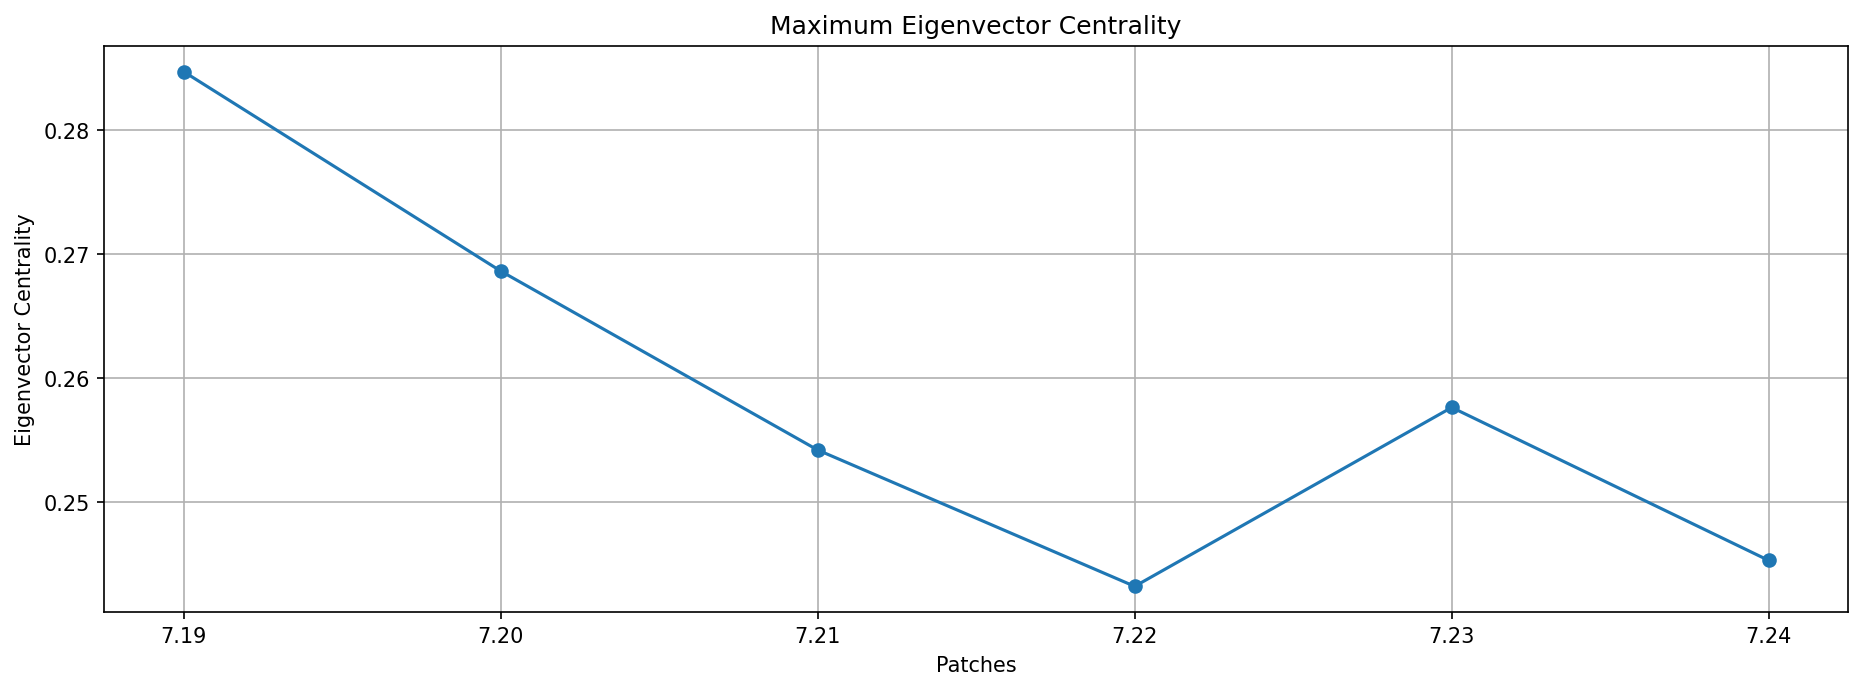

In [81]:
plot_eigen(df_eigen)

#### Ranking Comparison (Average Win Rate vs Eigenvector Centrality)

Traditionally, players and developers looked to the average win rates to see if a hero is balanced or not. Bus as mentioned earlier, this method does not account for directionality. In this section, the proponents will compare the rankings according to average win rate against the rankings according to eigenvector centrality. The difference between the two ranking columns is taken to highlight the resulting differences between the two methods.

In [82]:
df_ranks = pd.read_csv('winrates.csv')
df_ranks = df_ranks.drop('Unnamed: 0', axis=1)
df_ranks = pd.DataFrame(list(enumerate(df_ranks[df_ranks['patch']==7.24]
                                       .set_index('hero')['winrate']
                                       .sort_values(ascending=False)
                                       .index))).set_index(1)
df_ranks.columns = ['winrate_rank']

df_eigen_ranks = pd.DataFrame(list(enumerate(df_eigen['7.24']
                                             .sort_values(ascending=False)
                                             .index))).set_index(1)
df_eigen_ranks.columns = ['eigen_ranks']

df_final_ranks = df_ranks.join(df_eigen_ranks)
df_final_ranks['difference'] = df_final_ranks['winrate_rank']-df_final_ranks['eigen_ranks']

# del df_final_ranks.index.name
df_final_ranks.head(10)

,winrate_rank,eigen_ranks,difference
1,,,
underlord,0,1,-1
slardar,1,0,1
meepo,2,3,-1
clockwerk,3,4,-1
vengeful spirit,4,2,2
ogre magi,5,6,-1
bloodseeker,6,8,-2
huskar,7,7,0
naga siren,8,12,-4


##### Distribution of Differences

The histogram plot below shows that there are heroes whose ranks went as high up as 20 places, while there are also heroes whose ranks went down as much as 10 places. 

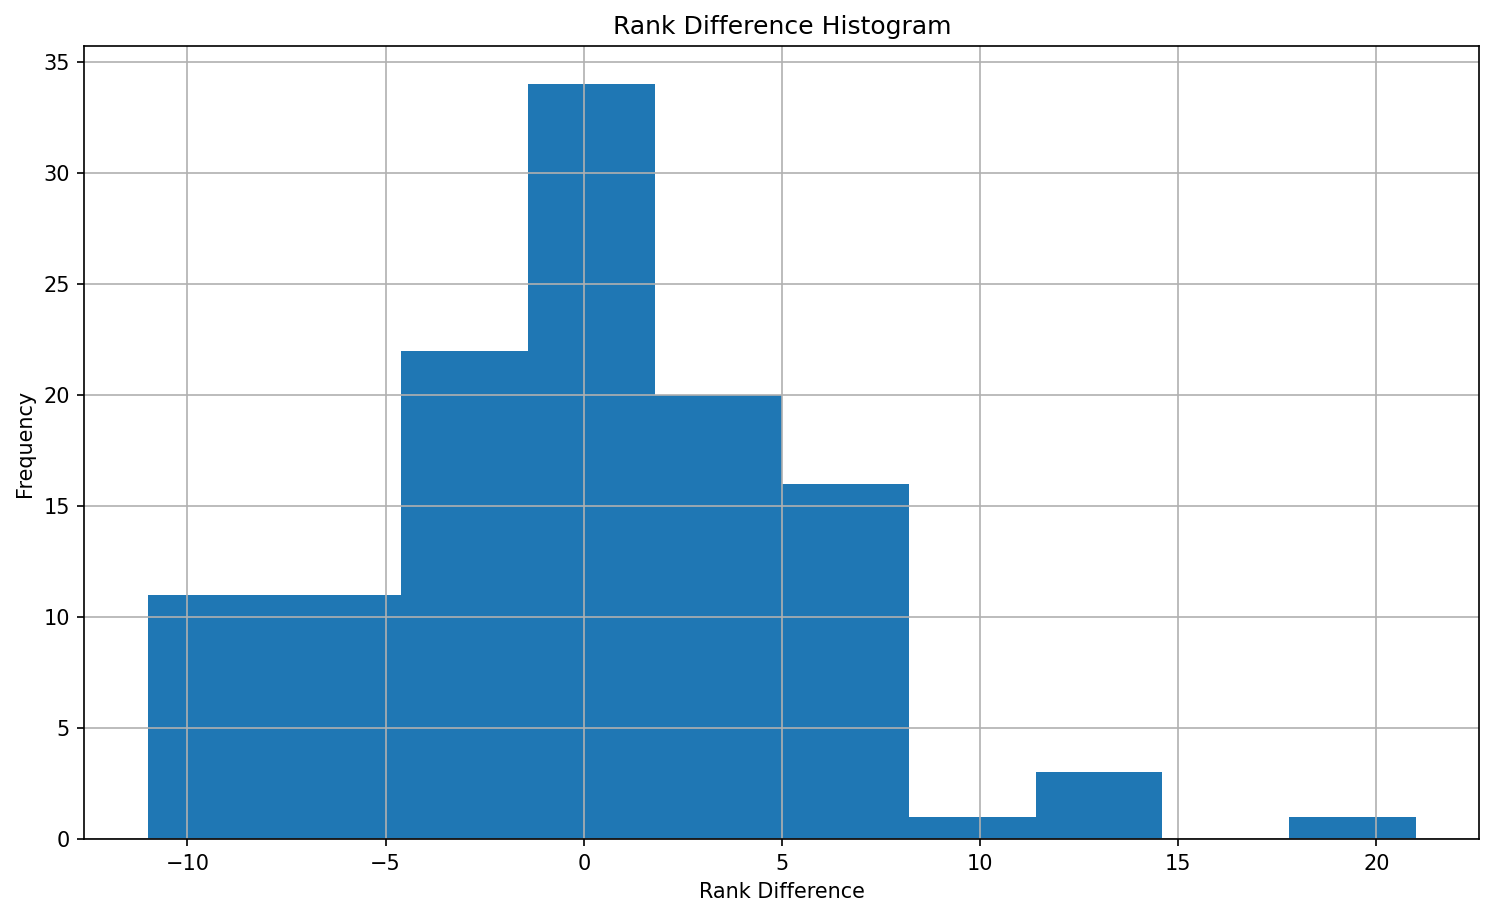

In [83]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_final_ranks.difference.hist(ax=ax)
ax.set_title('Rank Difference Histogram')
ax.set_xlabel('Rank Difference')
ax.set_ylabel('Frequency');

##### Rank Change

The change in rankings is difficult to visualize as a whole. As such the proponents will just be highlighting a few heroes. The ones with the highest shifts and the top 10 heroes according to win rates.

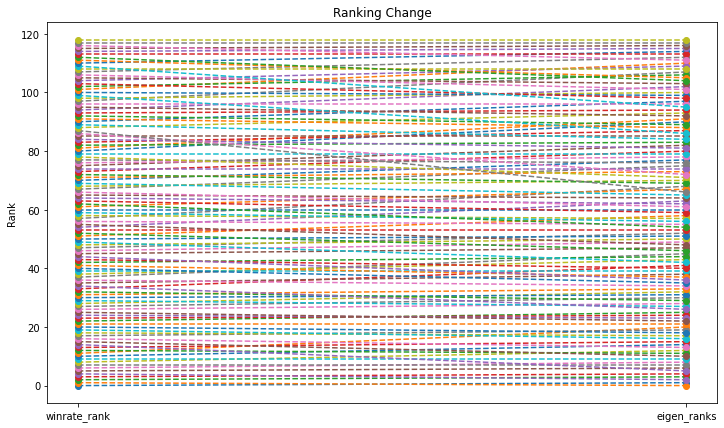

In [84]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df_final_ranks[['winrate_rank','eigen_ranks']].T, 'o--');
ax.set_title('Ranking Change')
ax.set_ylabel('Rank');

The plot below shows the heroes with the largest difference between average win rate in rank and eigenvector centrality rank. Broodmother has a 47% win rate for patch 7.24 but despite this, it maintains a 51.5% win rate against Clockwerk who is currently one of the top 10 heroes with around 53% win rate. This is because Broodmother is a hard counter to Clockwerk. Meanwhile, Storm Spirit and Timbersaw both increased in rank because they are both hard counters to Broodmother.

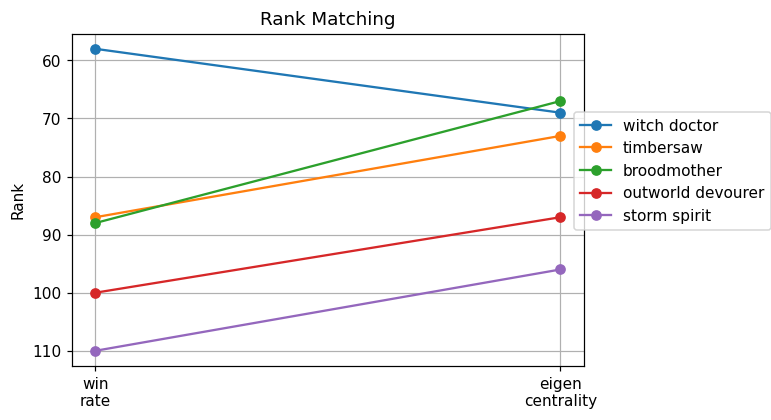

In [85]:
df_emphasis = df_final_ranks[(df_final_ranks['difference']<-10)|(df_final_ranks['difference']>10)]
fig, ax = plt.subplots(figsize=(6,4), dpi=110)
for ind, val in df_emphasis[['winrate_rank','eigen_ranks']].iterrows():
    ax.plot([-1*(val[0]+1), -1*(val[1]+1)], 'o-', label=ind)
ax.set_xticks([0,1])
ax.set_xticklabels(['win\nrate', 'eigen\ncentrality'])
ax.set_title('Rank Matching')
ax.grid()
# ax.set_ylim(0,120)
ax.set_yticklabels([120,110,100,90,80,70,60])
ax.set_ylabel('Rank')
fig.legend(bbox_to_anchor=(0.87, 0.7), loc='upper left', borderaxespad=0.);

The top 10 heroes (based on win rate) are also be compared via their eigenvector centrality ranks. And it can be seen that (based on eigenvector centrality) there are heroes that that shouldn't be in the top 10 and there are heroes that swapped and or jumped ranks. One of the highlights is Underlord vs Slardar. While Underlord has the highest win rate, Slardar is one of the heroes that can counter him (Underlord). In addition, Slardar is one of the few heroes that has a positive win rate against Underlord.

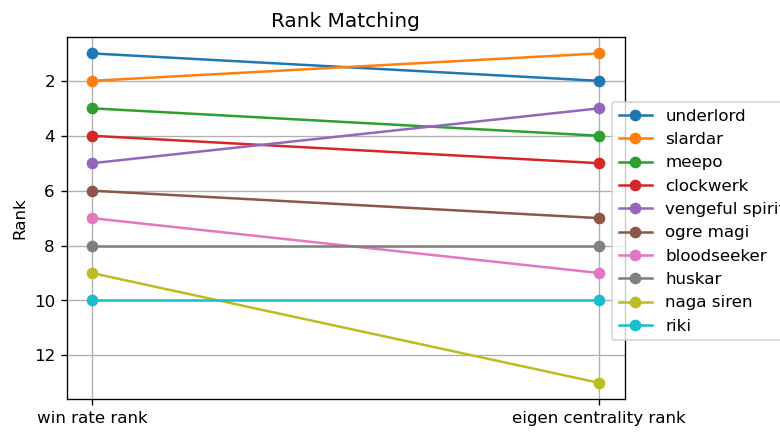

In [86]:
df_emphasis = df_final_ranks.iloc[:10]
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
for ind, val in df_emphasis[['winrate_rank','eigen_ranks']].iterrows():
    ax.plot([-1*(val[0]+1), -1*(val[1]+1)], 'o-', label=ind)
ax.set_xticks([0,1])
ax.set_xticklabels(['win rate rank', 'eigen centrality rank'])
ax.grid()
ax.set_title('Rank Matching')
ax.set_ylabel('Rank')
# ax.set_ylim(0,15)
ax.set_yticklabels([14,12,10,8,6,4,2])
fig.legend(bbox_to_anchor=(0.85, 0.7), loc='upper left', borderaxespad=0.);

## Conclusion

In this notebook we were able to show how Complex Network Analysis can provide a better, more holistic view of balance in a PvP video game. Through the use of Eigenvector centrality, we made some very interesting discoveries:

**1. Dota 2 is becoming more balanced with each successive patch.**

* This is a good sign as it means that the developers are doing a better job at improving player experience.

**2. The centrality measures follow a power law distribution, where the higher ranking heroes are the "meta" characters.**

* This means that player perception of "meta-heroes" are not just bias. But is actually a real phenomenon brought about by scale free networks.

**3. There are heroes that jumped as much as 40 ranks! Due to the fact that they are very good counters to the meta heroes.**

* This proves that win rate alone is not enough to justify if a hero is weak or strong.

Complex network analysis shows some very promising applications in the video game industry. One that is worth exploring more in the near future.

## Appendix

### In-Degree Centrality

The in-degree centrality for a node in a directed network is the fraction of nodes its incoming edges are connected to. In the context of the Dota 2 win rate network, the in-degree centrality is higher for heroes who can beat a lot of heroes when pitted against each other. The weights are not taken into account with this centrality measure, only the number of incoming edges. This means that we measure the strength of a hero based on the number of other heroes it can beat in battle.

#### In-Degre Centrality Distribution Across Patches

/Users/tinabargo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


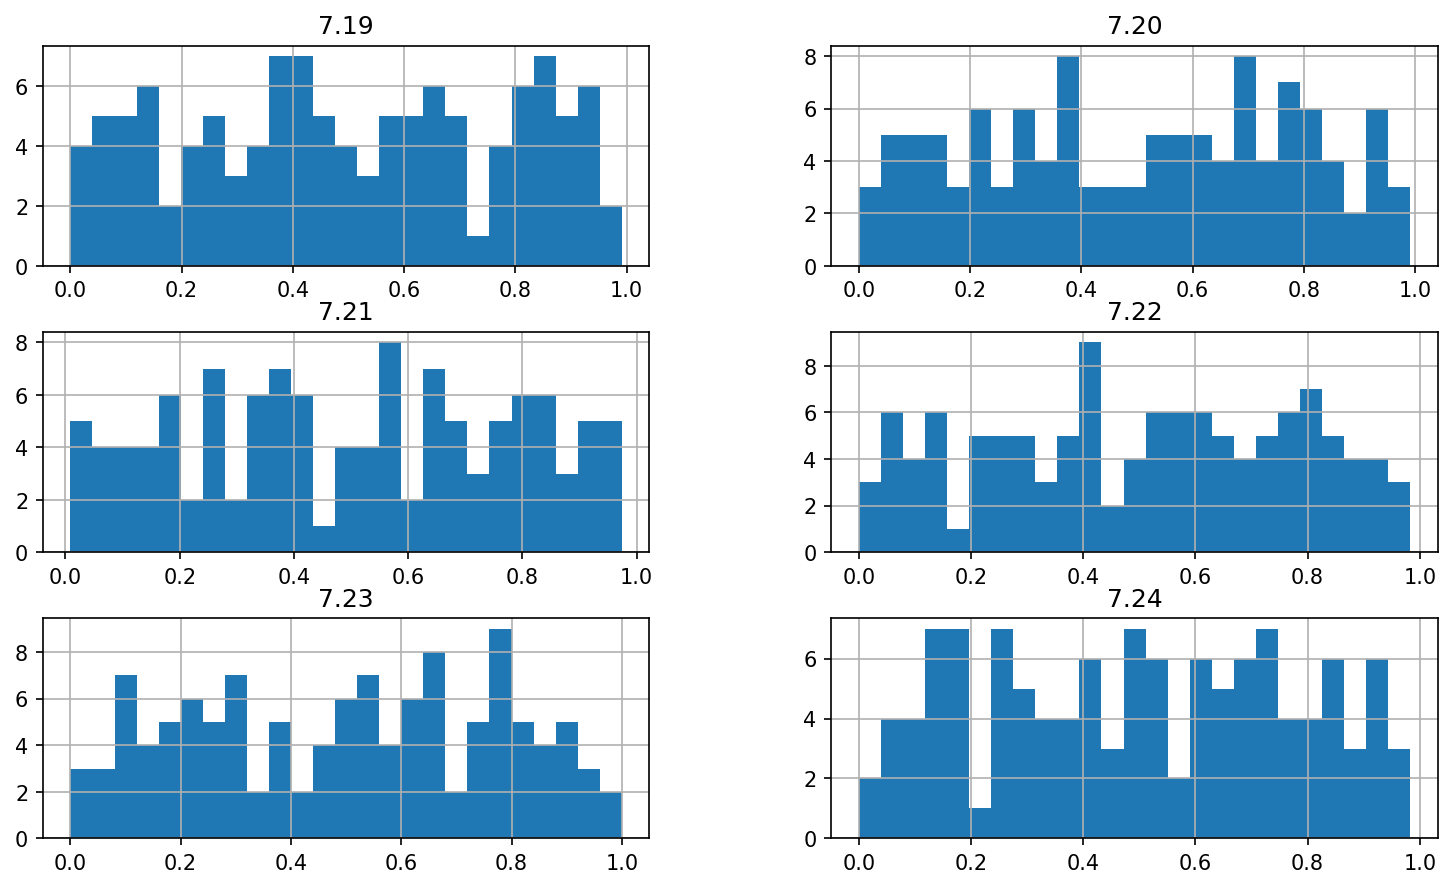

In [87]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_in.hist(figsize=(12,10),bins=25, ax=ax);

#### Ranking Comparison (Average Win Rate vs In-Degree Centrality)

In [88]:
df_ranks2 = pd.read_csv('winrates.csv')
df_ranks2 = df_ranks2.drop('Unnamed: 0', axis=1)
df_ranks2 = pd.DataFrame(list(enumerate(df_ranks2[df_ranks2['patch']==7.24]
                                        .set_index('hero')['winrate']
                                        .sort_values(ascending=False)
                                        .index))).set_index(1)
df_ranks2.columns = ['winrate_rank']

df_in_ranks = pd.DataFrame(list(enumerate(df_in['7.24']
                                          .sort_values(ascending=False)
                                          .index))).set_index(1)
df_in_ranks.columns = ['in_ranks']

df_final_ranks2 = df_ranks2.join(df_in_ranks)
df_final_ranks2['difference'] = df_final_ranks2['winrate_rank']-df_final_ranks2['in_ranks']

# del df_final_ranks.index.name
df_final_ranks2.head(10)

,winrate_rank,in_ranks,difference
1,,,
underlord,0,1,-1
slardar,1,0,1
meepo,2,8,-6
clockwerk,3,5,-2
vengeful spirit,4,2,2
ogre magi,5,3,2
bloodseeker,6,6,0
huskar,7,7,0
naga siren,8,20,-12


##### Distribution of DIfferences

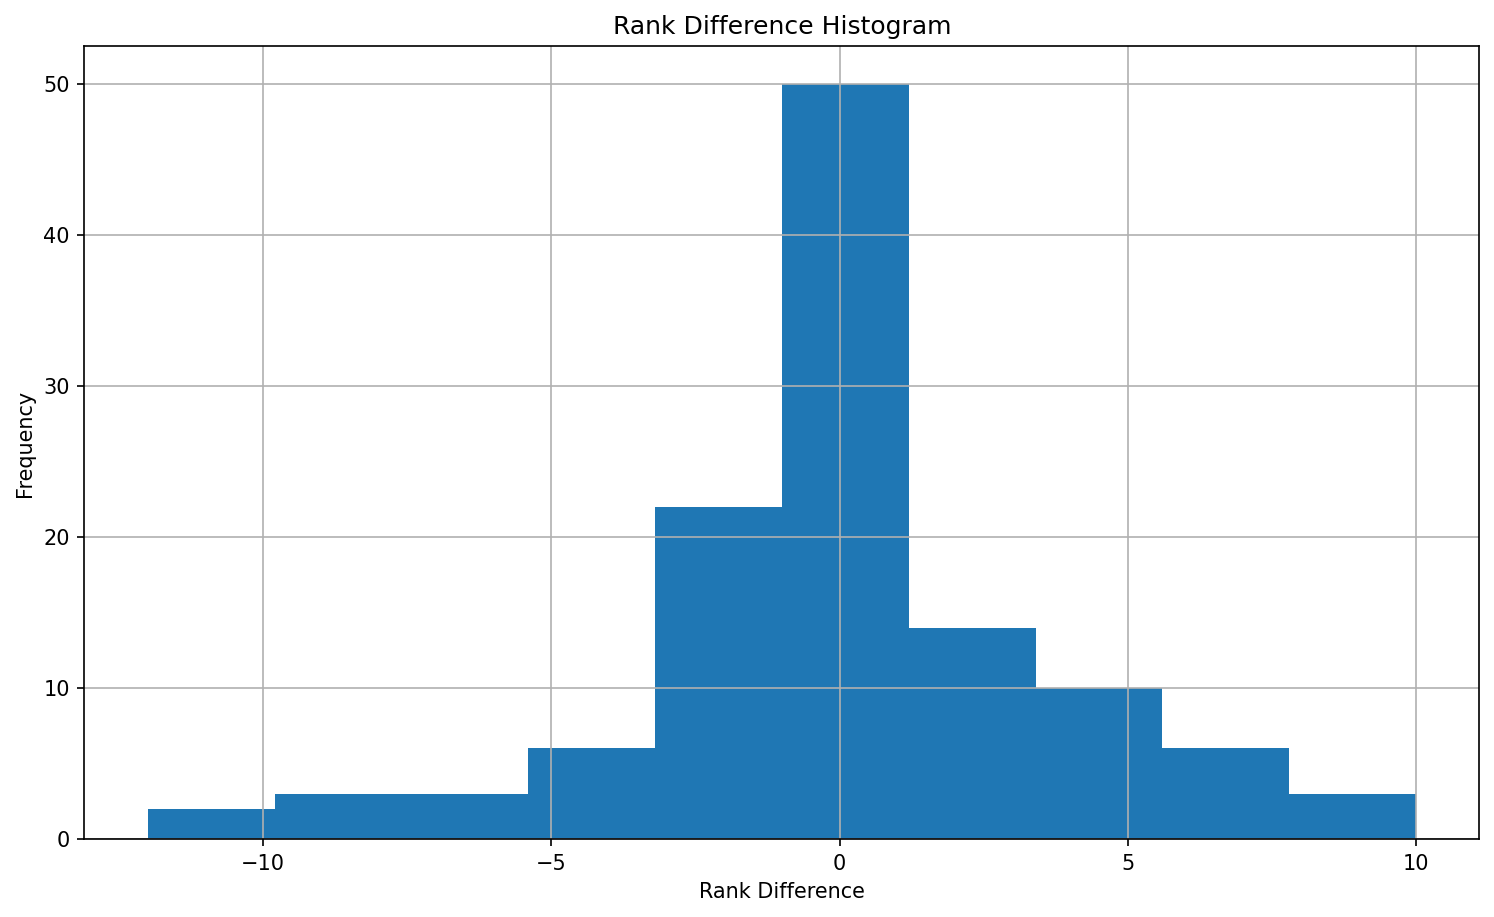

In [89]:
fig, ax = plt.subplots(figsize=(12,7), dpi=150)
df_final_ranks2.difference.hist(ax=ax)
ax.set_title('Rank Difference Histogram')
ax.set_xlabel('Rank Difference')
ax.set_ylabel('Frequency');

##### Rank Change

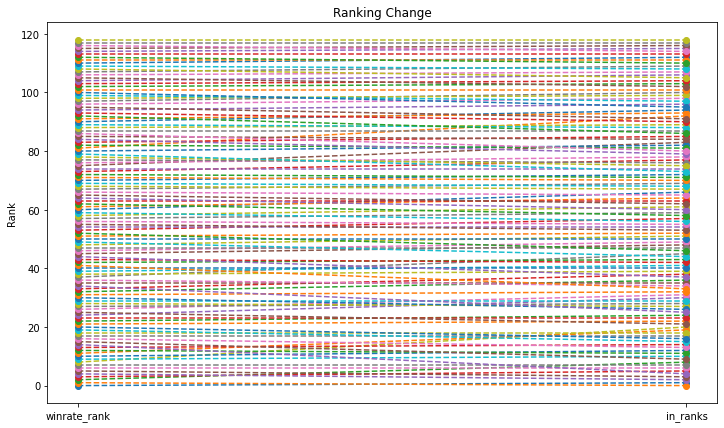

In [90]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df_final_ranks2[['winrate_rank','in_ranks']].T, 'o--');
ax.set_title('Ranking Change')
ax.set_ylabel('Rank');

###### Large jumps

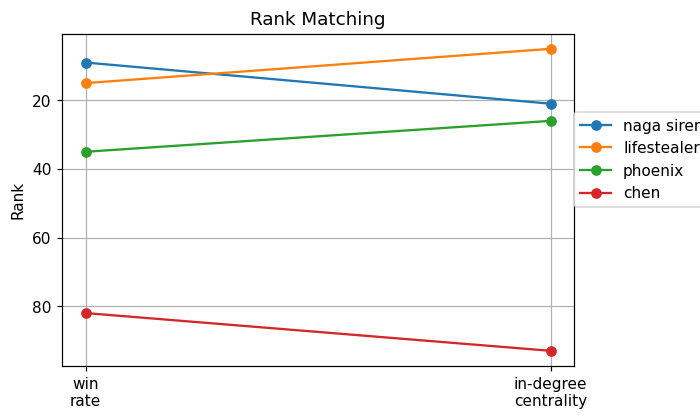

In [112]:
df_emphasis2 = df_final_ranks2[(df_final_ranks2['difference']<-8)|(df_final_ranks2['difference']>8)]
fig, ax = plt.subplots(figsize=(6,4), dpi=110)
for ind, val in df_emphasis2[['winrate_rank','in_ranks']].iterrows():
    ax.plot([-1*(val[0]+1), -1*(val[1]+1)], 'o-', label=ind)
ax.set_xticks([0,1])
ax.set_xticklabels(['win\nrate', 'in-degree\ncentrality'])
ax.set_title('Rank Matching')
ax.grid()
# ax.set_ylim(0,120)
ax.set_yticklabels([100,80,60,40,20,0])
ax.set_ylabel('Rank')
fig.legend(bbox_to_anchor=(0.87, 0.7), loc='upper left', borderaxespad=0.);

###### Top 10

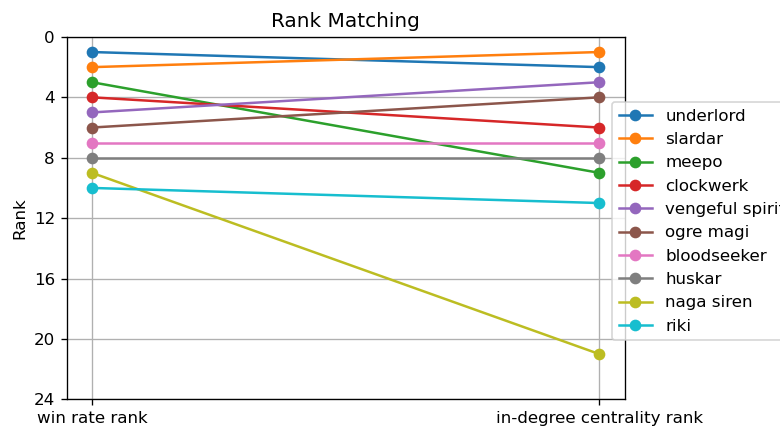

In [106]:
df_emphasis2 = df_final_ranks2.iloc[:10]
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
for ind, val in df_emphasis2[['winrate_rank','in_ranks']].iterrows():
    ax.plot([-1*(val[0]+1), -1*(val[1]+1)], 'o-', label=ind)
ax.set_xticks([0,1])
ax.set_xticklabels(['win rate rank', 'in-degree centrality rank'])
ax.grid()
ax.set_title('Rank Matching')
ax.set_ylabel('Rank')
ax.set_yticks([-24,-20,-16,-12,-8,-4,0])
# ax.set_ylim(0,15)
ax.set_yticklabels([24,20,16,12,8,4,0])
fig.legend(bbox_to_anchor=(0.85, 0.7), loc='upper left', borderaxespad=0.);

In [103]:
df_final_ranks2.head(20)

,winrate_rank,in_ranks,difference
1,,,
underlord,0,1,-1
slardar,1,0,1
meepo,2,8,-6
clockwerk,3,5,-2
vengeful spirit,4,2,2
ogre magi,5,3,2
bloodseeker,6,6,0
huskar,7,7,0
naga siren,8,20,-12


In [115]:
df_in.sort_values(by='7.24', ascending=False)

,7.19,7.20,7.21,7.22,7.23,7.24
slardar,0.373913,0.660870,0.482759,0.500000,0.762712,0.983051
underlord,0.826087,0.965217,0.931034,0.983051,1.000000,0.974576
vengeful spirit,0.913043,0.904348,0.870690,0.864407,0.983051,0.949153
ogre magi,0.773913,0.382609,0.681034,0.711864,0.864407,0.932203
clockwerk,0.573913,0.565217,0.646552,0.788136,0.906780,0.923729
...,...,...,...,...,...,...
natures prophet,0.034783,0.095652,0.146552,0.042373,0.203390,0.042373
earth spirit,0.086957,0.260870,0.077586,0.050847,0.000000,0.042373
tiny,0.052174,0.365217,0.060345,0.050847,0.550847,0.042373
gyrocopter,0.113043,0.069565,0.189655,0.381356,0.050847,0.008475


In [119]:
df_wins[(df_wins['from']=='naga siren') & (df_wins['patch']==7.24)]

,from,to,disadvantage,winrate_from,patch,number_matches,pairing,advantage
75416,naga siren,leshrac,6.97,2.98,7.24,11302.0,leshrac-naga siren,-6.97
75431,naga siren,enigma,3.31,1.81,7.24,7771.0,enigma-naga siren,-3.31
75432,naga siren,pangolier,3.13,0.94,7.24,20965.0,naga siren-pangolier,-3.13
75433,naga siren,gyrocopter,3.04,6.35,7.24,12131.0,gyrocopter-naga siren,-3.04
75434,naga siren,ember spirit,2.86,4.48,7.24,32298.0,ember spirit-naga siren,-2.86
...,...,...,...,...,...,...,...,...
75529,naga siren,riki,-4.65,4.53,7.24,28084.0,naga siren-riki,4.65
75530,naga siren,broodmother,-4.92,9.98,7.24,4840.0,broodmother-naga siren,4.92
75531,naga siren,lycan,-5.70,12.86,7.24,3428.0,lycan-naga siren,5.70
75532,naga siren,chaos knight,-5.75,9.98,7.24,11723.0,chaos knight-naga siren,5.75
